# 1. Imports & Configuration
All paths and hyper-parameters

In [1]:
# === Imports ===
import os, math, random, json, numpy as np
from typing import Dict, List, Tuple
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torch.amp import autocast, GradScaler
from tqdm import tqdm
import csv

SEED          = 42
BATCH_SIZE    = 16
NUM_EPOCHS    = 16
PAD_ID        = 4
VOCAB_SIZE    = 8000
WARMUP_RATIO  = 0.2
MAX_POS_LEN   = 320 
MIXUP_ALPHA = 0.3 
MIXUP_PROB  = 0.3     

# File names for checkpoint and training logs
DEVICE        = "cuda" if torch.cuda.is_available() else "cpu"
CHECKPOINT    = "Final_Mixcap_Checkpoints.pt"
MODEL_NAME    = "Mixcap_Final"
RESULTS_CSV_PATH = "/kaggle/working/results_log.csv"

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)


# === DATA PATHS ===
TRAIN_CAPTION_PATH = "/kaggle/input/mrsvtt-features-final-full-dataset/tokenizer/tokenized_captions/train_captions.npy"
VAL_CAPTION_PATH   = "/kaggle/input/mrsvtt-features-final-full-dataset/tokenizer/tokenized_captions/val_captions.npy"
VIDEO_FEATURE_DIR = "/kaggle/input/mrsvtt-features-final-full-dataset/train_set/video"
AUDIO_FEATURE_DIR = "/kaggle/input/mrsvtt-features-final-full-dataset/train_set/audio"

# 2. Dataset, Collate, and DataLoaders
Adds padding masks and mmap loading for faster IO.

In [2]:
class MultimodalCaptionDataset(Dataset):
    def __init__(self, video_dir: str, audio_dir: str, tokenized_caption_dict: Dict[str, List[List[int]]]):
        self.video_dir = video_dir
        self.audio_dir = audio_dir
        self.caption_dict = tokenized_caption_dict
        self.samples = [(vid, cap) for vid, caps in tokenized_caption_dict.items() for cap in caps]

    def __len__(self): 
        return len(self.samples)

    def __getitem__(self, idx):
        vid, caption = self.samples[idx]

        # Load video features and make writable
        video_np = np.load(os.path.join(self.video_dir, f"{vid}_video.npy"), mmap_mode="r")
        video = torch.from_numpy(np.copy(video_np)).float()

        # Load audio features and make writable
        try:
            audio_np = np.load(os.path.join(self.audio_dir, f"{vid}_audio.npy"), mmap_mode="r")
        except FileNotFoundError:
            audio_np = np.zeros((1, 1024), dtype=np.float32)
        audio = torch.from_numpy(np.copy(audio_np)).float()

        return dict(
            video=video,
            audio=audio,
            caption_in=torch.tensor(caption[:-1], dtype=torch.long),
            caption_tg=torch.tensor(caption[1:], dtype=torch.long)
        )


# === Padding Helpers ===
def pad_1d(seqs, pad_val=PAD_ID):
    max_len = max(s.size(0) for s in seqs)
    out = torch.full((len(seqs), max_len), pad_val, dtype=torch.long)
    lens = []
    for i, s in enumerate(seqs):
        out[i, :s.size(0)] = s
        lens.append(s.size(0))
    return out, torch.tensor(lens)

def pad_2d(feats):
    max_len = max(f.size(0) for f in feats)
    dim = feats[0].size(1)
    out = torch.zeros(len(feats), max_len, dim, dtype=feats[0].dtype)
    lens = []
    for i, f in enumerate(feats):
        out[i, :f.size(0)] = f
        lens.append(f.size(0))
    return out, torch.tensor(lens)

# === Collate Function for DataLoader ===
def multimodal_collate(batch):
    v, vlen = pad_2d([b["video"] for b in batch])
    a, alen = pad_2d([b["audio"] for b in batch])
    c_in, cin_len = pad_1d([b["caption_in"] for b in batch])
    c_tg, _       = pad_1d([b["caption_tg"] for b in batch])

    return dict(
        video=v, audio=a,
        video_len=vlen, audio_len=alen,
        cap_in=c_in, cap_tg=c_tg, cap_len=cin_len
    )

# === Load caption dicts & build loaders ===
train_caps = np.load(TRAIN_CAPTION_PATH, allow_pickle=True).item()
val_caps   = np.load(VAL_CAPTION_PATH,   allow_pickle=True).item()

train_ds = MultimodalCaptionDataset(VIDEO_FEATURE_DIR, AUDIO_FEATURE_DIR, train_caps)
val_ds   = MultimodalCaptionDataset(VIDEO_FEATURE_DIR, AUDIO_FEATURE_DIR, val_caps)

train_ld   = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=2, collate_fn=multimodal_collate, pin_memory=True)
val_ld     = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, collate_fn=multimodal_collate, pin_memory=True)

# 3. Model Architecture
Adds learned positional embeddings, dropout, causal + padding masks,
and bidirectional cross-attention encoder.

In [3]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len:int, dim:int):
        super().__init__()
        self.embed = nn.Embedding(max_len, dim)

    def forward(self, x):
        # x: (B, T, D)  → add positional embedding
        idx = torch.arange(x.size(1), device=x.device)
        return x + self.embed(idx)[None, :, :]

class CrossAttentionBlock(nn.Module):
    def __init__(self, dim:int, heads:int, dropout:float=0.1):
        super().__init__()
        self.attn   = nn.MultiheadAttention(dim, heads, dropout, batch_first=True)
        self.ff     = nn.Sequential(nn.Linear(dim, dim*4), nn.ReLU(), nn.Linear(dim*4, dim), nn.Dropout(dropout))
        self.norm1  = nn.LayerNorm(dim); self.norm2 = nn.LayerNorm(dim)

    def forward(self, q, kv, kv_mask=None):
        attn_out, _ = self.attn(q, kv, kv, key_padding_mask=kv_mask)
        x = self.norm1(q + attn_out)
        return self.norm2(x + self.ff(x))

# === Mixcap Encoder ===
class MixcapEncoder(nn.Module):
    def __init__(self, v_dim=1408, a_dim=1024, f_dim=768, layers=4, heads=8, dropout=0.1):
        super().__init__()
        self.v_proj = nn.Linear(v_dim, f_dim)
        self.a_proj = nn.Linear(a_dim, f_dim)
        self.pe     = PositionalEmbedding(MAX_POS_LEN, f_dim)
        self.drop   = nn.Dropout(dropout)

         # Cross-attention: video → audio and audio → video (bidirectional)
        self.v2a = nn.ModuleList([CrossAttentionBlock(f_dim, heads, dropout) for _ in range(layers)])
        self.a2v = nn.ModuleList([CrossAttentionBlock(f_dim, heads, dropout) for _ in range(layers)])

    def forward(self, v, a, v_mask=None, a_mask=None):
        v = self.drop(self.pe(self.v_proj(v)))
        a = self.drop(self.pe(self.a_proj(a)))
        for b_v2a, b_a2v in zip(self.v2a, self.a2v):
            v = b_v2a(v, a, kv_mask=a_mask)
            a = b_a2v(a, v, kv_mask=v_mask)
        return v, a

# === Transformer Decoder ===
class CaptionDecoder(nn.Module):
    def __init__(self, f_dim=768, vocab=VOCAB_SIZE, layers=4, heads=8, ff=2048, dropout=0.1):
        super().__init__()
        self.embed = nn.Embedding(vocab, f_dim, padding_idx=PAD_ID)
        self.pe    = PositionalEmbedding(MAX_POS_LEN, f_dim)
        dec_layer  = nn.TransformerDecoderLayer(f_dim, heads, ff, dropout, batch_first=True)
        self.trans = nn.TransformerDecoder(dec_layer, layers)
        self.out   = nn.Linear(f_dim, vocab)

    def _causal_mask(self, T, device):
        return torch.triu(torch.ones((T, T), dtype=torch.bool, device=device), 1)

    def forward(self, tgt, memory, tgt_pad_mask=None, mem_pad_mask=None):
        x      = self.pe(self.embed(tgt))
        T      = tgt.size(1)
        causal = self._causal_mask(T, tgt.device)
        out    = self.trans(x, memory,
                            tgt_mask=causal,
                            tgt_key_padding_mask=tgt_pad_mask,
                            memory_key_padding_mask=mem_pad_mask)
        return self.out(out)

# === Full Mixcap Model ===
# Combines encoder and decoder into one model
class MixcapModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = MixcapEncoder()
        self.dec = CaptionDecoder()

    def forward(self, v, a, tgt, v_mask=None, a_mask=None, tgt_pad_mask=None):
        v_enc, a_enc = self.enc(v, a, v_mask, a_mask)
        memory       = torch.cat([v_enc, a_enc], dim=1)
        mem_pad_mask = torch.cat([v_mask, a_mask], dim=1) if v_mask is not None else None
        return self.dec(tgt, memory, tgt_pad_mask, mem_pad_mask)

In [4]:
# --- MixUp Function
def feature_mixup(memory, captions, alpha=MIXUP_ALPHA):
    """
    Dual-target MixUp on fused sequence features.
      memory   : (B, T, D)   encoder output after concat
      captions : (B, L)      ground-truth caption IDs (tgt_tg)
    Returns: mem_mix, cap1, cap2, lam (scalar)
    """
    if alpha <= 0:
        return memory, captions, captions, 1.0

    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(memory.size(0), device=memory.device)

    mem_mix = lam * memory + (1.0 - lam) * memory[idx]
    cap1    = captions                 # original
    cap2    = captions[idx]            # shuffled
    return mem_mix, cap1, cap2, lam, idx

# 4. Loss, Scheduler, Train / Eval Loops
Includes label-smoothed CE, gradient clipping, AMP, and cosine LR.

In [5]:
class LabelSmoothedCE(nn.Module):
    def __init__(self, eps:float=0.1):
        super().__init__()
        self.eps = eps
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, logits, target):
        # logits: (B*T, V), target: (B*T)
        B, V = logits.size()
        log_probs = self.log_softmax(logits)
        nll = F.nll_loss(log_probs, target, ignore_index=PAD_ID, reduction='sum')
        smooth = -log_probs.sum(dim=-1)
        smooth = smooth[target != PAD_ID].sum()
        denom = (target != PAD_ID).sum().item()
        return (1 - self.eps) * nll / denom + self.eps * smooth / (denom * (V - 1))

def cosine_warmup(optim, warmup, total):
    def fn(step):
        if step < warmup: return step / max(1, warmup)
        progress = (step - warmup) / max(1, total - warmup)
        return max(0, 0.5 * (1 + math.cos(math.pi * progress)))
    return LambdaLR(optim, fn)

def lengths_to_mask(lens, max_len):
    return (torch.arange(max_len, device=lens.device)[None, :] >= lens[:, None])

def evaluate(model, loader, criterion):
    model.eval(); total_loss = 0

    with torch.no_grad(), autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
        for b in loader:
            video, audio = b['video'].to(DEVICE), b['audio'].to(DEVICE)
            v_mask = lengths_to_mask(b['video_len'].to(DEVICE), video.size(1))
            a_mask = lengths_to_mask(b['audio_len'].to(DEVICE), audio.size(1))
            tgt_in = b['cap_in'].to(DEVICE)
            tgt_tg = b['cap_tg'].to(DEVICE)
            tgt_pad = tgt_in.eq(PAD_ID)
            logits = model(video, audio, tgt_in, v_mask, a_mask, tgt_pad)
            loss = criterion(logits.view(-1, VOCAB_SIZE), tgt_tg.view(-1))
            total_loss += loss.item()
    return total_loss / len(loader)

with open(RESULTS_CSV_PATH, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["Model", "Epoch", "Train Loss", "Val Loss"])


def train(model, train_ld, val_ld):
    model.to(DEVICE)
    optim = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    total_steps = len(train_ld) * NUM_EPOCHS
    sched  = cosine_warmup(optim, int(total_steps * WARMUP_RATIO), total_steps)
    criterion = LabelSmoothedCE(0.1)
    scaler    = GradScaler(enabled=torch.cuda.is_available())


    best = float('inf')
    patience_counter = 0
    PATIENCE = 3

    for epoch in range(1, NUM_EPOCHS + 1):
        model.train(); epoch_loss = 0
        prog = tqdm(train_ld, desc=f"Epoch {epoch}/{NUM_EPOCHS}")
        for b in prog:
            video, audio = b['video'].to(DEVICE), b['audio'].to(DEVICE)
            v_mask = lengths_to_mask(b['video_len'].to(DEVICE), video.size(1))
            a_mask = lengths_to_mask(b['audio_len'].to(DEVICE), audio.size(1))
            tgt_in = b['cap_in'].to(DEVICE)
            tgt_tg = b['cap_tg'].to(DEVICE)
            tgt_pad = tgt_in.eq(PAD_ID)

            optim.zero_grad()
            with autocast(device_type='cuda' if torch.cuda.is_available() else 'cpu'):
                # === 1. Encode video/audio ===
                v_enc, a_enc = model.enc(video, audio, v_mask, a_mask)
                memory       = torch.cat([v_enc, a_enc], dim=1)
                mem_pad_mask = torch.cat([v_mask, a_mask], dim=1)
            
                # ----- 2. Maybe apply MixUp -----
                mix_prob = 0.3 * max(0.0, min(1.0, (epoch - 1) / 3)) 
                if random.random() < mix_prob:
                    memory_mixed, cap1, cap2, lam, idx = feature_mixup(memory, tgt_tg, alpha=MIXUP_ALPHA)
                    mem_pad_mask_mixed = mem_pad_mask | mem_pad_mask[idx]
                    memory_to_use = memory_mixed
                    mem_pad_mask_to_use = mem_pad_mask_mixed
                    is_mixup = True
   
                else:
                    memory_to_use = memory
                    mem_pad_mask_to_use = mem_pad_mask
                    cap1 = cap2 = tgt_tg
                    lam = 1.0
                    is_mixup = False
                    lam  = 1.0
            
                # ----- 3. Decode -----
                logits = model.dec(tgt_in, memory_to_use, tgt_pad, mem_pad_mask_to_use)
                
                # # ----- 4. Dual-target loss -----
                ce1 = criterion(logits.view(-1, VOCAB_SIZE), cap1.view(-1))
                if is_mixup:
                    ce2 = criterion(logits.view(-1, VOCAB_SIZE), cap2.view(-1))
                    loss = lam * ce1 + (1.0 - lam) * ce2
                else:
                    loss = ce1

                # ----- 5. Back-prop + optimiser step -----
                scaler.scale(loss).backward()
                scaler.unscale_(optim)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optim)
                scaler.update()
                sched.step()
                epoch_loss += loss.item()           


        train_loss = epoch_loss / len(train_ld)
        val_loss   = evaluate(model, val_ld, criterion)
        print(f"Epoch {epoch}: train {train_loss:.4f} | val {val_loss:.4f}")

        if val_loss < best:
            best = val_loss
            patience_counter = 0
            torch.save({
                "model": model.state_dict(),
                "optim": optim.state_dict(),
                "scaler": scaler.state_dict(),
                "sched": sched.state_dict(),
                "epoch": epoch
            }, CHECKPOINT)
            print(f"Saved new best to {CHECKPOINT}")
        else:
            patience_counter += 1
            print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
            if patience_counter >= PATIENCE:
                print("Early stopping triggered.")
                break

        # Log each epoch's result to CSV
        with open(RESULTS_CSV_PATH, "a") as f:
            writer = csv.writer(f)
            writer.writerow([MODEL_NAME, epoch, train_loss, val_loss])

# 5. Inference Helper & Training Entry Point
Greedy decode for evaluation.

In [6]:
@torch.no_grad()
def generate_caption(model, video_np:np.ndarray, audio_np:np.ndarray, max_len:int=30):
    model.eval()
    video = torch.from_numpy(video_np).unsqueeze(0).float().to(DEVICE)
    audio = torch.from_numpy(audio_np).unsqueeze(0).float().to(DEVICE)
    v_mask = torch.zeros(1, video.size(1), dtype=torch.bool, device=DEVICE)
    a_mask = torch.zeros(1, audio.size(1), dtype=torch.bool, device=DEVICE)

    tgt = torch.tensor([[5]], dtype=torch.long, device=DEVICE)  # SOS = 5
    for _ in range(max_len):
        logits = model(video, audio, tgt, v_mask, a_mask, tgt.eq(PAD_ID))
        next_tok = logits[:, -1].argmax(-1, keepdim=True)
        tgt = torch.cat([tgt, next_tok], dim=1)
        if next_tok.item() == 6:  # EOS = 6
            break
    return tgt.squeeze().tolist()

#  BLEU-4 and CIDEr Evaluation
This block evaluates the final model on the validation set using standard COCO caption metrics (BLEU-4 and CIDEr). 
- It uses greedy decoding
- Logs the scores to the results CSV

In [7]:
!git clone https://github.com/salaniz/pycocoevalcap.git
%cd pycocoevalcap
!pip install .
%cd ..

Cloning into 'pycocoevalcap'...
remote: Enumerating objects: 821, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 821 (delta 4), reused 3 (delta 3), pack-reused 809 (from 2)
Receiving objects: 100% (821/821), 130.06 MiB | 46.44 MiB/s, done.
Resolving deltas: 100% (424/424), done.
/kaggle/working/pycocoevalcap
Processing /kaggle/working/pycocoevalcap
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=36b6a2e21cb5084ce6abae9bc768ac78fe7ff5d5c144abcecb9403d24b6fdec3
  Stored in directory: /tmp/pip-ephem-wheel-cache-cqx8pc_h/wheels/e1/95/5b/9a3357937c812a0ff04bc78701371bb96f914719385ff3183f
Successfully built pycocoevalcap
/kaggle/working


In [8]:
# ================================
# BLEU-4 and CIDEr Evaluation Block
# ================================
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.bleu.bleu import Bleu

def evaluate_captions(model, dataset, sp_model, max_samples=500):
    model.eval()
    gts, res = {}, {}

    for i in range(min(max_samples, len(dataset))):
        sample = dataset[i]
        vid = dataset.samples[i][0]

        video_np = sample['video'].numpy()
        audio_np = sample['audio'].numpy()
        pred_ids  = generate_caption(model, video_np, audio_np)
        pred_text = sp_model.decode_ids(pred_ids)
    
        # Get all 20 tokenized captions for this video from the full dict
        all_gt_caps = dataset.caption_dict[vid]
        ref_texts = [sp_model.decode_ids(cap) for cap in all_gt_caps]
    
        gts[vid] = ref_texts    
        res[vid] = [pred_text]

    bleu = Bleu(4)
    cider = Cider()

    bleu_score, _ = bleu.compute_score(gts, res)
    cider_score, _ = cider.compute_score(gts, res)

    print(f"\n BLEU-4: {bleu_score[3]:.2f} | CIDEr: {cider_score:.2f}")

    # Append to results log
    with open(RESULTS_CSV_PATH, "a") as f:
        writer = csv.writer(f)
        writer.writerow([MODEL_NAME, "FinalEval", f"BLEU-4: {bleu_score[3]:.4f}", f"CIDEr: {cider_score:.4f}"])

In [9]:
# === MAIN ===
if __name__ == "__main__":
    import sentencepiece as spm
    sp = spm.SentencePieceProcessor()
    sp.load("/kaggle/input/mrsvtt-features-final-full-dataset/tokenizer/spm.model")

    model = MixcapModel()
    train(model, train_ld, val_ld)
    print("Training complete. Best model saved at:", CHECKPOINT)


# Load best model
    ckpt = torch.load(CHECKPOINT)
    model.load_state_dict(ckpt["model"])

    # === Save model-only weights ===
    torch.save(model.state_dict(), "MixCap_model_only.pth")
    print("Saved model-only weights to MixCap_model_only.pth")

    # Inference on one sample
    vid_feat = np.load("/kaggle/input/mrsvtt-features-final-full-dataset/train_set/video/video1001_video.npy")
    aud_feat = np.load("/kaggle/input/mrsvtt-features-final-full-dataset/train_set/audio/video1001_audio.npy")

    output_ids = generate_caption(model, vid_feat, aud_feat)
    print("Token IDs:", output_ids)

    # Decode to text
    decoded = sp.decode_ids(output_ids)
    print("Decoded Caption:", decoded)

    # Evaluate with BLEU-4 and CIDEr
    evaluate_captions(model, val_ds, sp)

Epoch 1/16: 100%|██████████| 8142/8142 [13:10<00:00, 10.30it/s]


Epoch 1: train 5.2329 | val 4.5353
Saved new best to Final_Mixcap_Checkpoints.pt


Epoch 2/16: 100%|██████████| 8142/8142 [13:14<00:00, 10.24it/s]


Epoch 2: train 4.4420 | val 4.2934
Saved new best to Final_Mixcap_Checkpoints.pt


Epoch 3/16: 100%|██████████| 8142/8142 [13:35<00:00,  9.98it/s]


Epoch 3: train 4.3282 | val 4.3081
No improvement. Patience: 1/3


Epoch 4/16: 100%|██████████| 8142/8142 [13:28<00:00, 10.08it/s]


Epoch 4: train 4.3398 | val 4.2388
Saved new best to Final_Mixcap_Checkpoints.pt


Epoch 5/16: 100%|██████████| 8142/8142 [13:14<00:00, 10.24it/s]


Epoch 5: train 4.2157 | val 4.2058
Saved new best to Final_Mixcap_Checkpoints.pt


Epoch 6/16: 100%|██████████| 8142/8142 [14:13<00:00,  9.54it/s]


Epoch 6: train 4.0999 | val 4.1927
Saved new best to Final_Mixcap_Checkpoints.pt


Epoch 7/16: 100%|██████████| 8142/8142 [13:43<00:00,  9.89it/s]


Epoch 7: train 3.9763 | val 4.1744
Saved new best to Final_Mixcap_Checkpoints.pt


Epoch 8/16: 100%|██████████| 8142/8142 [13:21<00:00, 10.16it/s]


Epoch 8: train 3.8597 | val 4.1578
Saved new best to Final_Mixcap_Checkpoints.pt


Epoch 9/16: 100%|██████████| 8142/8142 [13:17<00:00, 10.21it/s]


Epoch 9: train 3.7404 | val 4.1339
Saved new best to Final_Mixcap_Checkpoints.pt


Epoch 10/16: 100%|██████████| 8142/8142 [13:15<00:00, 10.24it/s]


Epoch 10: train 3.5933 | val 4.1298
Saved new best to Final_Mixcap_Checkpoints.pt


Epoch 11/16: 100%|██████████| 8142/8142 [13:31<00:00, 10.03it/s]


Epoch 11: train 3.4625 | val 4.1455
No improvement. Patience: 1/3


Epoch 12/16: 100%|██████████| 8142/8142 [13:36<00:00,  9.98it/s]


Epoch 12: train 3.3596 | val 4.1620
No improvement. Patience: 2/3


Epoch 13/16: 100%|██████████| 8142/8142 [13:16<00:00, 10.22it/s]


Epoch 13: train 3.2502 | val 4.1831
No improvement. Patience: 3/3
Early stopping triggered.
Training complete. Best model saved at: Final_Mixcap_Checkpoints.pt
Saved model-only weights to MixCap_model_only.pth
Token IDs: [5, 7, 39, 27, 200, 7, 309, 40, 339, 39, 27, 134, 589, 25, 286, 6]
Decoded Caption: a man is singing a song and another man is playing guitar in stage
{'testlen': 164, 'reflen': 170, 'guess': [164, 139, 114, 89], 'correct': [150, 97, 50, 21]}
ratio: 0.9647058823472665

 BLEU-4: 0.49 | CIDEr: 0.75


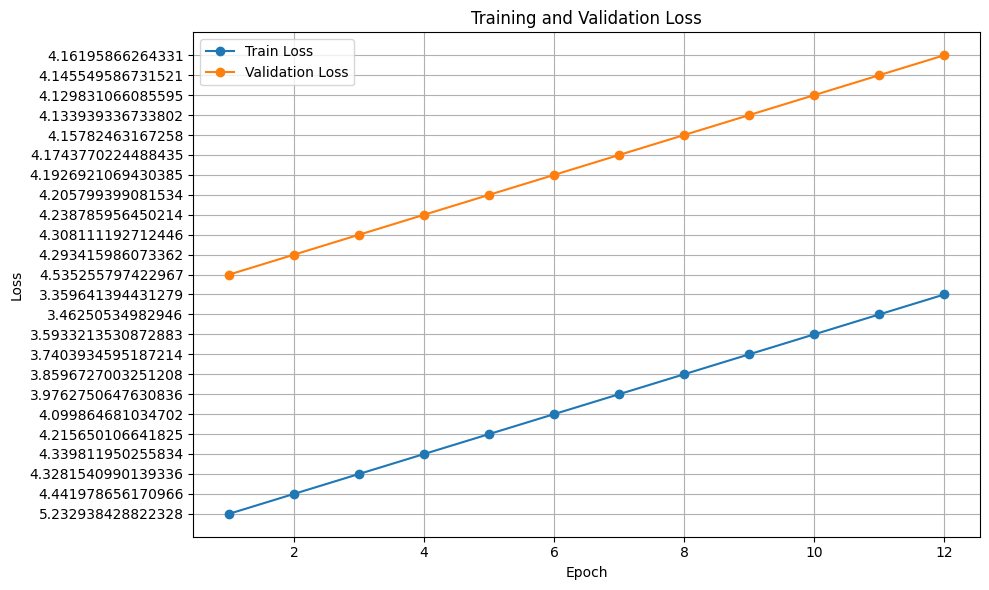

In [10]:

# === Plot loss curve ===
import matplotlib.pyplot as plt
import pandas as pd

csv_path = RESULTS_CSV_PATH 
df = pd.read_csv(csv_path)

# Filter out non-numeric rows (e.g., BLEU-4/CIDEr lines)
df = df[pd.to_numeric(df["Epoch"], errors="coerce").notnull()]
df["Epoch"] = df["Epoch"].astype(int)

plt.figure(figsize=(10, 6))
plt.plot(df["Epoch"], df["Train Loss"], label="Train Loss", marker='o')
plt.plot(df["Epoch"], df["Val Loss"], label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_curve.png")
plt.show()

In [11]:
import zipfile
with zipfile.ZipFile("MixCap_model_only.zip", "w") as z:
    z.write("MixCap_model_only.pth")